In [3]:
import pandas as pd

### 文本去重

In [4]:
Data =  pd.read_csv('./comments.csv', sep=',', encoding='utf-8')

# 重复的文本数量
Data.duplicated().sum()

3

In [5]:
# 去除3行重复的评论
comment_unique = Data.drop_duplicates()

# 形状
comment_unique.shape

# 统计每条评论的字数
length = [len(i) for i in comment_unique.iloc[:,0]]
length = pd.DataFrame(length)


# 将iPhoneX_comment_compress和length连接，生成一个新的对象
DataClear = pd.concat([comment_unique, length],axis=1) 

#重新命名列名
DataClear.columns = ["评论", '字数']

# 删除评论长度<6的评论
Comment = DataClear[DataClear["字数"] > 5]  

#获取前5条记录
DataClear.head(5)


,评论,字数
0,一直认为写作是件很耗费体力与脑力的事情，特别是从新构架一个新的世界，一个文明。这需要你有丰富...,210.0
1,有点屌，也有点“作者语文是物理老师教的”的感觉,23.0
2,幼稚，各种。对人性、对社会的运作方式的理解处在小学生水准，对女人的想象处在童男子水准。另外就...,116.0
3,流水账似的科幻小说。作者的文字能力、人物塑造能力和想象力都很有限，思考也不深入，就是框架很宏...,50.0
4,大刘不是文笔平庸，是根本没有文笔和人物。三体之所以仍旧很好看，的确仰赖其在物理、历史、数学、...,103.0


In [7]:
import jieba

wordsCut = Comment["评论"].astype("str").apply(lambda x: jieba.lcut(x))

stopWords = pd.read_csv('./stoplist.txt', sep='fenci', encoding='utf-8', header=None, engine='python')

# 去除停用词
wordStop = wordsCut.apply(lambda x: [i for i in x if i not in list(stopWords.iloc[:,0])])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.940 seconds.
Prefix dict has been built successfully.


### 下面给出绘制评论文本的词云图

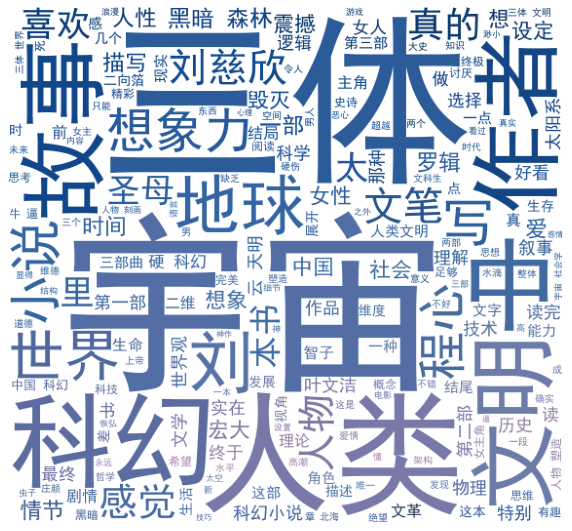

In [46]:
from imageio import imread
from wordcloud import WordCloud,ImageColorGenerator
import matplotlib.pyplot as plt  

wordTemp = []

for i in wordStop.index:
  wordTemp.extend(wordStop.loc[i])
wordStop_df = pd.DataFrame(wordTemp)
wordStop_df.columns = ["words"]
result= "/".join(wordTemp)
plt.rcParams['figure.figsize'] = (10.0, 10.0)

#自定义词云背景图片
image =imread("./bg.jpg")

#构建词云模型
wordcloud = WordCloud(background_color="white", mask=image,font_path=r"C:\Windows\Fonts\simhei.ttf", max_font_size=200)
wordcloud.generate(result) 

#从背景图片生成词云图中文字的颜色
image_color = ImageColorGenerator(image)  
wordcloud.recolor(color_func=image_color)
#保存绘制好的词云图，比直接程序显示的图片更清晰
wordcloud.to_file(r"cloud.png")  

#显示词云图图片
plt.figure("词云图")   #指定所绘图名称
plt.imshow(wordcloud)  #以图片的形式显示词云
plt.axis("off")        # 关闭图像坐标系
plt.show()

In [47]:
#评论文本情感倾向分析
#读取情感字典文件
feeling = pd.read_csv("./BosonNLP.txt",sep = " ",encoding = "utf-8",header =None)
#重新命名列名
feeling.columns = ["word","score"]    

print('feeling的前5行：\n',feeling.head(5))

feeling的前5行：
       word     score
0      最尼玛 -6.704000
1       扰民 -6.497564
2  fuck... -6.329634
3      RNM -6.218613
4  wcnmlgb -5.967100


In [48]:
#导入否定词词库，并新增1列为'value'，取值全部为-1
notdict = pd.read_csv("./not.csv",encoding='utf-8')
notdict['value'] = -1
print('notdict的前5行：\n',notdict.head(5))

notdict的前5行：
   term  value
0    不     -1
1    没     -1
2    无     -1
3    非     -1
4    莫     -1


In [49]:
# 将wordStop_df，否定词表，词语情感分值表合并
# 保留坐标的未匹配的值，
# 选出否定词， df[words, term, value]
df = pd.merge(wordStop_df, notdict, how='left', left_on='words', right_on='term')

# 词汇打分，用感情词的word匹配文本words
df = pd.merge(df, feeling, how= 'left', left_on = 'words', right_on='word')

df.drop(['term','word'],axis=1,inplace= True)

print('df的前5行：\n',df.head(5))

df的前5行：
   words  value     score
0    写作    NaN -0.736532
1     件    NaN  0.523179
2    耗费    NaN -0.231462
3    体力    NaN -0.997829
4    脑力    NaN -1.076923


In [50]:
#统计每条记录的词语数目，方便后续判断每个词语的句子归属
length=[len(wordStop.iloc[i]) for i in range(wordStop.shape[0])]

#给各词语指定归属标号，即词语所属记录的序号
ID = []
for i in range(len(length)):
    ID.extend([i]*length[i])
#将ID作为df的index
df.index = ID
print('将ID作为df的index后的df的前5行：\n',df.head(5))

将ID作为df的index后的df的前5行：
   words  value     score
0    写作    NaN -0.736532
0     件    NaN  0.523179
0    耗费    NaN -0.231462
0    体力    NaN -0.997829
0    脑力    NaN -1.076923


In [51]:
#获取不含有否定词的句子的ID
noneNotId = list(df.loc[df['value'].isnull(),:].index)

#新建pandas对象存放句子的情感分值
dfScore = pd.DataFrame(index = list(set(df.index)),columns = ['Score'])

#将没有否定词的句子的所有词的情感分值相加
for i in noneNotId:
    dfScore.loc[i,'Score'] = df.loc[i,'score'].sum()

print('dfScore的前5行：\n',dfScore.head(5))

dfScore的前5行：
        Score
0  12.185485
1  -1.950498
2   9.851594
3   7.103956
4   9.563566


In [52]:
#取出含有否定词的句子ID
NotID = list(set(df.loc[df['value'].notnull(),:].index))

#以value为基础合并，若df['value']的数据缺失,则用df['score']的数据值填充
df['score1'] = df['value'].combine_first(df['score'])
df['score1'] = df['score1'].fillna(0)   #用0填充nan数据
print('以value为基础合并后的df的前5行：\n',df.head(5))

以value为基础合并后的df的前5行：
   words  value     score    score1
0    写作    NaN -0.736532 -0.736532
0     件    NaN  0.523179  0.523179
0    耗费    NaN -0.231462 -0.231462
0    体力    NaN -0.997829 -0.997829
0    脑力    NaN -1.076923 -1.076923


In [53]:
NotScore = []
for i in NotID:
    score = 0

    #取出其中一个有否定词句子的index和score1
    Ser = df.loc[i,'score1']  
    
    #获取句子包含的总共词语数目
    lenNot = Ser.shape[0]     
    cirlist = [k for k in range(lenNot)]
    cirlist .reverse()

    #从后往前计算一个句子的情感分值，防止最前面出现否定词无效
    for j in cirlist: 
        
        #若句子的最后一个词为否定词，Score初始化为-1
        if  Ser.iloc[j] == -1: 
            if j == (lenNot-1):
                score = -1
            elif (j ==0) & (Ser.iloc[j+1]!=-1):
                #在遇见-1时，前项已经加过，因而应将前项减去再加上(-1*得分)
                score = score- Ser.iloc[j] + (-1* Ser.iloc[j])
            else:
                if (Ser.iloc[j+1]!=-1) & (Ser.iloc[j-1]!=-1):
                    score = score- Ser.iloc[j] + (-1* Ser.iloc[j])
                    #在双重否定的情况下，不需要做操作
                    #本算法不考虑多重否定
        else:
            score += Ser.iloc[j]

    NotScore.append(score)

dfScore.loc[NotID, 'Score'] = NotScore
wordStop=wordStop.reset_index(drop=True)
feelScore = pd.concat([dfScore,wordStop],axis = 1)
pos = feelScore.loc[feelScore['Score'] > 0,['Score','评论']]
print('pos的前5行\n',pos.head(5))
neg = feelScore.loc[feelScore['Score'] < 0,['Score','评论']]
print('neg的前5行\n',neg.head(5))


pos的前5行
        Score                                                 评论
0  12.185485  [写作, 件, 耗费, 体力, 脑力, 事情, 特别, 是从, 新, 构架, 新, 世界, ...
2   9.851594  [幼稚, 人性, 社会, 运作, 方式, 理解, 小学生, 水准, 女人, 想象, 童, 男...
3   7.103956  [流水账, 科幻小说, 作者, 文字, 能力, 人物, 塑造, 能力, 想象力, 有限, 思...
4   9.563566  [刘, 文笔, 平庸, 文笔, 人物, 三体, 好看, 仰赖, 物理, 历史, 数学, 哲学...
7    6.56903  [文科生, 尽力, 真的, 好看, 逻辑, 松散, 文笔, 差, 人物, 个性, 从头到尾,...
neg的前5行
        Score                                                 评论
1  -1.950498                         [屌, 作者, 语文, 物理, 老师, 教, 感觉]
5  -0.622039  [感觉, 泼冷水, 之日, 意识, 看过, 这书, 感觉, 故事会, 网文, 综合体, 雨果...
6  -0.341983                   [最牛, 逼, 科幻, 疯狂, 想象, 写, 新闻报道, 真实]
10 -3.280645                             [论文, 笔, 重要性, 讲, 砸, 故事]
16 -2.368497  [创意, 厉害, 物理, 名词, 理科, 不好, 文科生, 不太, 友好, 阅读, 过程, 吃力]


In [54]:
#下面给出评论文本的LDA主题分析的代码实现
from gensim import corpora, models

pos = feelScore.loc[feelScore['Score'] > 0,'评论']
neg = feelScore.loc[feelScore['Score'] < 0,'评论']
#负面主题分析
#建立负面词典
neg_dict = corpora.Dictionary(neg)              
#建立负面语料库
neg_corpus = [neg_dict.doc2bow(i) for i in neg] 

#构建LDA模型
neg_lda = models.LdaModel(neg_corpus, num_topics = 3, id2word = neg_dict) 
print("\n负面评价")
for i in range(3):
    print("主题%d : " %i)
    #输出主题
    print(neg_lda.print_topic(i) ) 

#正面主题分析
pos_dict = corpora.Dictionary(pos)
pos_corpus = [pos_dict.doc2bow(i) for i in pos]
pos_lda = models.LdaModel(pos_corpus, num_topics = 3, id2word = pos_dict)
print("\n正面评价")
for i in range(3):
    print("主题%d : " %i)
    # 输出主题
    print(pos_lda.print_topic(i) ) 


负面评价
主题0 : 
0.012*"三体" + 0.011*"人类" + 0.009*"小说" + 0.008*" " + 0.008*"圣母" + 0.007*"感觉" + 0.007*"真的" + 0.006*"作者" + 0.006*"写" + 0.006*"程心"
主题1 : 
0.012*"逼" + 0.007*"真的" + 0.007*"中国" + 0.007*"写" + 0.006*"太" + 0.006*"感觉" + 0.006*"科幻" + 0.005*"毁灭" + 0.005*"故事" + 0.005*"高潮"
主题2 : 
0.010*"科幻" + 0.010*"感觉" + 0.008*"写" + 0.008*"硬" + 0.008*"＂" + 0.007*" " + 0.007*"文明" + 0.006*"小说" + 0.006*"三体" + 0.006*"真的"

正面评价
主题0 : 
0.009*"三体" + 0.008*"科幻" + 0.008*"宇宙" + 0.006*"中" + 0.006*"刘" + 0.005*"刘慈欣" + 0.004*"人物" + 0.004*"里" + 0.004*"人类" + 0.004*"程心"
主题1 : 
0.011*"宇宙" + 0.009*" " + 0.008*"三体" + 0.008*"科幻" + 0.007*"人类" + 0.007*"世界" + 0.005*"文笔" + 0.005*"喜欢" + 0.005*"刘" + 0.004*"中"
主题2 : 
0.021*" " + 0.009*"宇宙" + 0.008*"三体" + 0.008*"文明" + 0.006*"中" + 0.006*"作者" + 0.006*"科幻" + 0.006*"地球" + 0.006*"故事" + 0.005*"人类"
